<a href="https://colab.research.google.com/github/Linaqruf/sd-checkpoint-merger-cli/blob/main/checkpoint_merger_cli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![visitor][visitor-badge]][visitor-stats]
<!-- [![ko-fi][ko-fi-badge]][ko-fi-link] -->

# **Checkpoint Merger CLI**
A Colab Notebook To Merge Checkpoint Without Need to Setup Automatic1111

[visitor-badge]: https://api.visitorbadge.io/api/visitors?path=%20Checkpoint%20Merger%20CLI&label=Visitors&labelColor=%2334495E&countColor=%231ABC9C&style=flat&labelStyle=none
[visitor-stats]: https://visitorbadge.io/status?path=%20Checkpoint%20Merger%20CLI
[ko-fi-badge]: https://img.shields.io/badge/Support%20me%20on%20Ko--fi-F16061?logo=ko-fi&logoColor=white&style=flat
[ko-fi-link]: https://ko-fi.com/linaqruf

| Notebook Name | Description | Link |
| --- | --- | --- |
| [Kohya LoRA Trainer XL](https://github.com/Linaqruf/kohya-trainer/blob/main/kohya-LoRA-trainer-XL.ipynb) | LoRA Training | [![](https://img.shields.io/static/v1?message=Open%20in%20Colab&logo=googlecolab&labelColor=5c5c5c&color=0f80c1&label=%20&style=flat)](https://colab.research.google.com/github/Linaqruf/kohya-trainer/blob/main/kohya-LoRA-trainer-XL.ipynb) |
| [Kohya Trainer XL](https://github.com/Linaqruf/kohya-trainer/blob/main/kohya-trainer-XL.ipynb) | Native Training | [![](https://img.shields.io/static/v1?message=Open%20in%20Colab&logo=googlecolab&labelColor=5c5c5c&color=0f80c1&label=%20&style=flat)](https://colab.research.google.com/github/Linaqruf/kohya-trainer/blob/main/kohya-trainer-XL.ipynb) |


In [ ]:
#@title ## **Install Checkpoint Merger CLI**
import os
import torch
from subprocess import getoutput

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# Directories
root_dir = "/content"
repo_dir = os.path.join(root_dir, "sd-checkpoint-merger-cli")
models_dir = os.path.join(root_dir, "models")
outputs_dir = os.path.join(root_dir, "outputs")

os.makedirs(outputs_dir, exist_ok=True)

# Repository details
repo_url = "https://github.com/Linaqruf/sd-checkpoint-merger-cli" #@param {type:"string"}
branch = "main" #@param {type:"string"}

def clone_repo(url, dir, branch):
    if not os.path.exists(dir):
       !git clone -b {branch} {url} {dir}

def setup_directories(dirs):
    for dir in dirs:
        os.makedirs(dir, exist_ok=True)

def install_dependencies():
    !apt install aria2
    !pip install -q diffusers accelerate transformers omegaconf

def prepare_environment():
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
    os.environ["PYTHONWARNINGS"] = "ignore"
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "garbage_collection_threshold:0.9,max_split_size_mb:512"
    os.environ["TCMALLOC_AGGRESSIVE_DECOMMIT"] = "t"
    os.environ["CUDA_MODULE_LOADING"] = "LAZY"

def main():

    os.chdir(root_dir)
    clone_repo(repo_url, repo_dir, branch)
    os.chdir(repo_dir)
    setup_directories([repo_dir, models_dir])
    install_dependencies()
    prepare_environment()

main()

In [ ]:
# @title ## **Download SDXL**
import os
import re
import json
import glob
import gdown
import requests
import subprocess
from urllib.parse import urlparse, unquote
from pathlib import Path

os.chdir(root_dir)

# @markdown Place your Huggingface [Read Token](https://huggingface.co/settings/tokens) Here.

HUGGINGFACE_TOKEN = ""  # @param {type: "string"}
SDXL_MODEL_URLS = ""  # @param {type: "string"}

def get_supported_extensions():
    return tuple([".ckpt", ".safetensors", ".pt", ".pth"])

def get_filename(url):
    extensions = get_supported_extensions()

    if url.endswith(tuple(extensions)):
        filename = os.path.basename(url)
    else:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        if 'content-disposition' in response.headers:
            content_disposition = response.headers['content-disposition']
            filename = re.findall('filename="?([^"]+)"?', content_disposition)[0]
        else:
            url_path = urlparse(url).path
            filename = unquote(os.path.basename(url_path))

    if filename.endswith(tuple(get_supported_extensions())):
        return filename
    else:
        return None

def parse_args(config):
    args = []

    for k, v in config.items():
        if k.startswith("_"):
            args.append(f"{v}")
        elif isinstance(v, str) and v is not None:
            args.append(f'--{k}={v}')
        elif isinstance(v, bool) and v:
            args.append(f"--{k}")
        elif isinstance(v, float) and not isinstance(v, bool):
            args.append(f"--{k}={v}")
        elif isinstance(v, int) and not isinstance(v, bool):
            args.append(f"--{k}={v}")

    return args

def aria2_download(dir, filename, url):
    user_header = f"Authorization: Bearer {HUGGINGFACE_TOKEN}"

    aria2_config = {
        "console-log-level"         : "error",
        "summary-interval"          : 10,
        "header"                    : user_header if "huggingface.co" in url else None,
        "continue"                  : True,
        "max-connection-per-server" : 16,
        "min-split-size"            : "1M",
        "split"                     : 16,
        "dir"                       : dir,
        "out"                       : filename,
        "_url"                      : url,
    }
    aria2_args = parse_args(aria2_config)
    subprocess.run(["aria2c", *aria2_args])

def gdown_download(url, dst, filepath):
    if "/uc?id/" in url or "/file/d/" in url:
        return gdown.download(url, filepath, quiet=False)
    elif "/drive/folders/" in url:
        os.chdir(dst)
        return gdown.download_folder(url, quiet=True, use_cookies=False)

def download(url, dst):
    filename = get_filename(url)
    filepath = os.path.join(dst, filename)

    if "drive.google.com" in url:
        gdown = gdown_download(url, dst, filepath)
    elif url.startswith("/content/drive/MyDrive/"):
        return url
    else:
        if "huggingface.co" in url:
            if "/blob/" in url:
                url = url.replace("/blob/", "/resolve/")
        aria2_download(dst, filename, url)

def main():
    model_urls = SDXL_MODEL_URLS.split(",")
    for model_path in model_urls:
        model_path = model_path.strip()  # remove any leading or trailing whitespace
        download(model_path, models_dir)
        print(f"Model downloaded at: {model_path}")

main()


Loading checkpoint...
Checkpoint: /content/models/animagine-v2-base-000009.safetensors

Merging Models:
  - Primary Model:   /content/models/animagine-v2-base-000009.safetensors
  - Secondary Model: /content/models/animagine-v2-aesthetic-000004.safetensors
  - Tertiary Model:  /content/models/animagine-v2-base-000009.safetensors
Interpolation Method: add-difference
Multiplier: 0.8
Tensor Halving: Enabled
Discard Weights: None

Loading /content/models/animagine-v2-aesthetic-000004.safetensors...
Loading /content/models/animagine-v2-base-000009.safetensors...
Merging secondary and tertiary models.
Loading /content/models/animagine-v2-base-000009.safetensors...
Merging primary and secondary models.
Saving Merged Model:
  - Path: /content/outputs/model.safetensors
  - File Format: SafeTensors


Inference Parameters:
  - Prompt: masterpiece, best quality, expressive eyes, perfect face, 1girl, kafka, looking at viewer, upper body, outdoors, night
  - Negative Prompt: lowres, bad anatomy, bad

  0%|          | 0/50 [00:00<?, ?it/s]

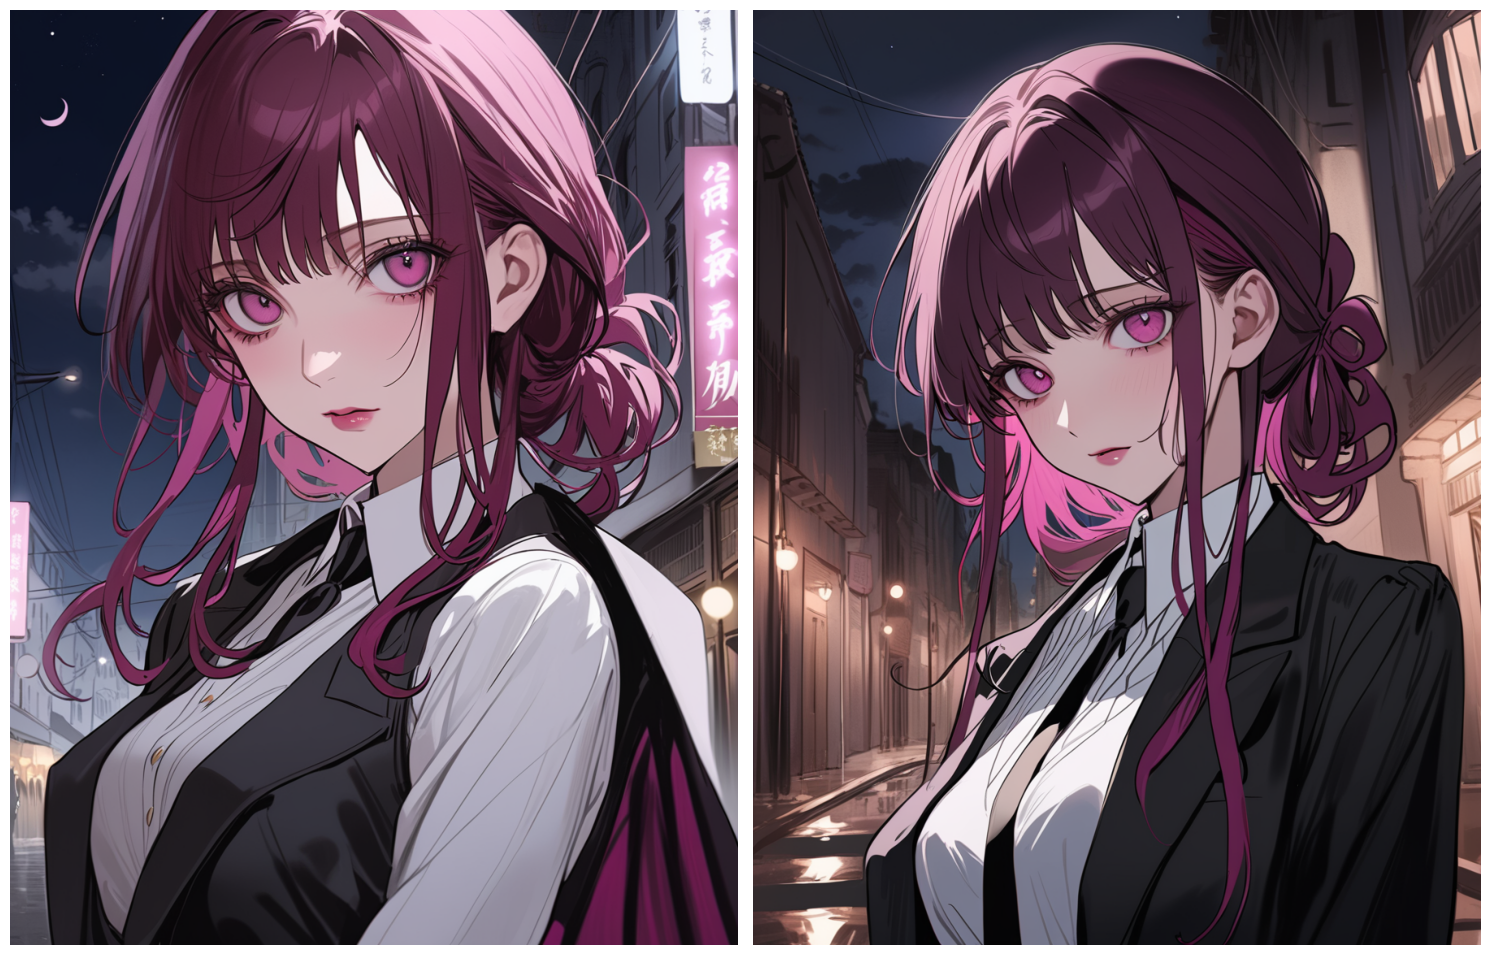

4082

In [23]:
# @title ## **Start Merging**
os.chdir(repo_dir)

from checkpoint_merger_cli import checkpoint_merger
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
import gc

# @markdown ## **Merging Config**
INTERPOLATION = "add-difference" # @param ["add-difference", "weighted-sum"]
# @markdown 1. Weighted Sum and Add Difference are methods to combine models.

# @markdown 2. Weighted Sum formula:
# @markdown > Result = `A * (1 - M) + B * M`

# @markdown - where A and B are the two models and M is the multiplier.

# @markdown 3. Add Difference requires a third model, C, and is calculated as:
# @markdown > Result = `A + (B - C) * M`
MODEL_A = "/content/models/animagine-v2-base-000009.safetensors" # @param {type:"string"}
MODEL_B = "/content/models/animagine-v2-aesthetic-000004.safetensors" # @param {type:"string"}
MODEL_C = "/content/models/animagine-v2-base-000009.safetensors" # @param {type:"string"}
MULTIPLIER = 0.8 # @param {type:"slider", min:0, max:1, step:0.05}
MODEL_OUTPUT = "/content/outputs/model.safetensors" # @param {type:"string"}
SDXL = True # @param {type:"boolean"}
FP16 = True # @param {type:"boolean"}
# @markdown ## **Inference Config**
PROMPT = "masterpiece, best quality, expressive eyes, perfect face, 1girl, kafka, looking at viewer, upper body, outdoors, night" # @param {type:"string"}
NEGATIVE = "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry" # @param {type:"string"}
RESOLUTION = "896,1152" # @param {type:"string"}
IMAGES_PER_PROMPT = 2 # @param {type:"number"}
STEPS = 50  # @param {type:"number"}
SCALE = 12 # @param {type:"number"}
SEED = -1 # @param {type:"number"}
SAMPLER = "Euler a" # @param ["DPM++ 2M", "DPM++ 2M Karras", "DPM++ 2M SDE", "DPM++ 2M SDE Karras", "DPM++ SDE", "DPM++ SDE Karras", "DPM2", "DPM2 Karras", "Euler", "Euler a", "Heun", "LMS", "LMS Karras", "DDIMScheduler", "DEISMultistepScheduler", "UniPCMultistepScheduler"]

WIDTH, HEIGHT = RESOLUTION.split(",")

args_dict = {
    "primary_model"   : MODEL_A,
    "output_path"     : MODEL_OUTPUT,
    "tertiary_model"  : MODEL_C,
    "secondary_model" : MODEL_B,
    "interpolation"   : INTERPOLATION,
    "multiplier"      : MULTIPLIER,
    "sdxl"            : SDXL,
    "half"            : FP16,
    "prompt"          : f"{PROMPT} --n {NEGATIVE} --w {WIDTH} --h {HEIGHT} --s {STEPS} --l {SCALE} --t {IMAGES_PER_PROMPT}" + (f" --d {SEED}" if SEED >= 0 else ""),
    "image_output"    : os.path.join(outputs_dir, "image.png"),
    "sampler"         : SAMPLER,
    "disable_torch_compile": True,
}

images = checkpoint_merger(**args_dict)

num_images = len(images)
cols = min(4, num_images)  # Limiting to 4 columns for better visualization; adjust as needed
rows = math.ceil(num_images / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, 15))  # adjust figsize as needed

for idx, img in enumerate(images):
    row = idx // cols
    col = idx % cols
    if rows == 1:
        ax = axs[col]
    elif cols == 1:
        ax = axs[row]
    else:
        ax = axs[row, col]
    ax.imshow(np.array(img))
    ax.axis('off')

for idx in range(num_images, rows * cols):
    row = idx // cols
    col = idx % cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
gc.collect()



## **Deploy**

In [ ]:
# @title ### **Huggingface Hub config**
from huggingface_hub import login, HfApi
from huggingface_hub.utils import validate_repo_id, HfHubHTTPError

# @markdown Login to Huggingface Hub
# @markdown > Get **your** huggingface `WRITE` token [here](https://huggingface.co/settings/tokens)
write_token = ""  # @param {type:"string"}
# @markdown Fill this if you want to upload to your organization, or just leave it empty.
orgs_name = ""  # @param{type:"string"}
# @markdown If your model repo does not exist, it will automatically create it.
model_name = ""  # @param {type:"string"}
make_private = False  # @param{type:"boolean"}

def authenticate(write_token):
    login(write_token, add_to_git_credential=True)
    api = HfApi()
    return api.whoami(write_token), api

def create_model_repo(api, user, orgs_name, model_name, make_private=False):
    if orgs_name == "":
        repo_id = user["name"] + "/" + model_name.strip()
    else:
        repo_id = orgs_name + "/" + model_name.strip()

    try:
        validate_repo_id(repo_id)
        api.create_repo(repo_id=repo_id, repo_type="model", private=make_private)
        print(f"Model repo '{repo_id}' didn't exist, creating repo")
    except HfHubHTTPError as e:
        print(f"Model repo '{repo_id}' exists, skipping create repo")

    print(f"Model repo '{repo_id}' link: https://huggingface.co/{repo_id}\n")

    return repo_id

user, api = authenticate(write_token)

if model_name:
    model_repo = create_model_repo(api, user, orgs_name, model_name, make_private)


In [ ]:
# @title ### **Upload to Huggingface**
from huggingface_hub import HfApi
from pathlib import Path
import os

api = HfApi()

# @markdown This will be uploaded to model repo
model_path = ""  # @param {type :"string"}
path_in_repo = ""  # @param {type :"string"}
project_name = os.path.basename(model_path)

# @markdown Other Information
commit_message = ""  # @param {type :"string"}

def is_diffusers_model(model_path):
    required_folders = {"unet", "text_encoder", "text_encoder_2", "tokenizer", "tokenizer_2", "scheduler", "vae"}
    return required_folders.issubset(set(os.listdir(model_path))) and os.path.isfile(os.path.join(model_path, "model_index.json"))

def upload_model(model_paths, is_folder: bool):
    path_obj = Path(model_paths)
    trained_model = path_obj.parts[-1]

    path_in_repo_local = path_in_repo if path_in_repo and not is_diffusers_model(model_paths) else ""

    notification = f"Uploading {trained_model} from {model_paths} to https://huggingface.co/{model_repo}"
    print(notification)

    if is_folder:
        if is_diffusers_model(model_paths):
            commit_message = f"Upload diffusers format: {trained_model}"
            print("Detected diffusers model. Adjusting upload parameters.")
        else:
            commit_message = f"Upload checkpoint: {trained_model}"
            print("Detected regular model. Adjusting upload parameters.")

        api.upload_folder(
            folder_path=model_paths,
            path_in_repo=path_in_repo_local,
            repo_id=model_repo,
            commit_message=commit_message,
            ignore_patterns=".ipynb_checkpoints",
        )
    else:
        commit_message = f"Upload file: {trained_model}"
        api.upload_file(
            path_or_fileobj=model_paths,
            path_in_repo=path_in_repo_local,
            repo_id=model_repo,
            commit_message=commit_message,
        )

    success_notification = f"Upload successful. Check the model at https://huggingface.co/{model_repo}/tree/main"
    print(success_notification)

def upload():
    if model_path.endswith((".ckpt", ".safetensors", ".pt")):
        upload_model(model_path, False)
    else:
        upload_model(model_path, True)

upload()
